In [685]:
import numpy as np
import pandas as pd
import math
import cv2
import matplotlib.pyplot as plt
from matplotlib import path
import random
import collections
from PIL import Image
from skimage.feature import local_binary_pattern

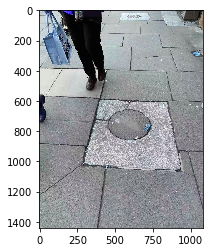

In [1258]:
i = 20

img = cv2.imread(str(i) + ".jpg")
plt.imshow(img)

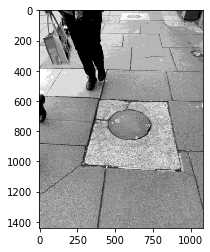

In [1261]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
out = fast_glcm_mean(gray)
plt.imshow(out, 'gray')

In [687]:
def LBP(img):
    
    width = img.shape[1]
    height = img.shape[0]
    
    # Normalize
    img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
    
    # Convert it into grey-level image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Guided Filtering
    guided = cv2.ximgproc.guidedFilter(guide=gray, src=img, radius=21, eps = int(np.max(img.shape)), dDepth=-1)
    gg = cv2.cvtColor(guided, cv2.COLOR_RGB2GRAY)
    
    a = int(np.percentile(gg, 25))
    b = int(np.percentile(gg, 75))
    c = int(np.percentile(gg, 50))

    gg_new = gg.reshape(gg.shape[0]*gg.shape[1])

    A = gg.min()
    B = gg.max()
    
    for i in range(gg_new.shape[0]):
        if gg_new[i] > b:
            gg_new[i] = int((255 - 64) + 64 * (gg_new[i] - b)/(B - b))
        elif gg_new[i] < a:
            gg_new[i] = int(64 * (gg_new[i] - A)/(a - A))
        else:
            gg_new[i] = int(64 + (190 - 64 + 1) * (gg_new[i] - a)/(b-a))
        
    gg = gg_new.reshape(gg.shape[0], gg.shape[1])
    
    out = local_binary_pattern(gg, 8, 1)
    
    return out

In [688]:
# fig = plt.figure(figsize=(20,20))

# ax = plt.subplot(121)
# lbp = LBP(img).astype('int')
# plt.imshow(lbp, 'gray')

# ax = plt.subplot(122)
# # Convert it into grey-level image
# gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
# # Guided Filtering
# guided = cv2.ximgproc.guidedFilter(guide=gray, src=img, radius=21, eps = int(np.max(img.shape)), dDepth=-1)
# gg = cv2.cvtColor(guided, cv2.COLOR_RGB2GRAY)
# plt.imshow(local_binary_pattern(gg, 8, 1), 'gray')

In [689]:
def fast_glcm(img, vmin=0, vmax=255, nbit=8, kernel_size=5):
    mi, ma = vmin, vmax
    ks = kernel_size
    h,w = img.shape

    # digitize
    bins = np.linspace(mi, ma+1, nbit+1)
    gl1 = np.digitize(img, bins) - 1
    gl2 = np.append(gl1[:,1:], gl1[:,-1:], axis=1)

    # make glcm
    glcm = np.zeros((nbit, nbit, h, w), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            mask = ((gl1==i) & (gl2==j))
            glcm[i,j, mask] = 1

    kernel = np.ones((ks, ks), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            glcm[i,j] = cv2.filter2D(glcm[i,j], -1, kernel)

    glcm = glcm.astype(np.float32)
    return glcm

In [690]:
def fast_glcm_mean(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm mean
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            mean += glcm[i,j] * i / (nbit)**2

    return mean

In [1262]:
def fast_glcm_contrast(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm contrast
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    cont = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            cont += glcm[i,j] * (i-j)**2

    return cont

In [1263]:
def fast_glcm_ASM(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm asm, energy
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    asm = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            asm  += glcm[i,j]**2

    ene = np.sqrt(asm)
    return asm, ene

In [1264]:
def fast_glcm_entropy(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm entropy
    '''
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    pnorm = glcm / np.sum(glcm, axis=(0,1)) + 1./ks**2
    ent  = np.sum(-pnorm * np.log(pnorm), axis=(0,1))
    return ent

In [1265]:
def fast_glcm_homogeneity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm homogeneity
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    homo = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            homo += glcm[i,j] / (1.+(i-j)**2)

    return homo

In [691]:
def pre(img):
    
    show = img[: , : , : : -1]
    width = img.shape[1]
    height = img.shape[0]
    
    # Normalize
    img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
    
    # Convert it into grey-level image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # GLCM
    glcm_mean = fast_glcm_mean(gray)
    
    # Normalize
    temp = np.array(cv2.normalize(glcm_mean, glcm_mean, 0, 255, cv2.NORM_MINMAX), np.uint8)
    
    # Edge detection
    a = int(np.percentile(temp, 25))
    b = int(np.percentile(temp, 75))
    edge = cv2.Canny(temp, a, b)
    
    return (show, edge)

In [692]:
IMG = list()
EDGE = list()
OUT = list()

for i in range(47):
    img = cv2.imread(str(i) + ".jpg")
    (img, edge) = pre(img)
    edge_show = np.expand_dims(edge, axis=2)
    edge_show = np.concatenate((edge_show, edge_show, edge_show), axis=-1)
    out = np.concatenate((img, edge_show), axis = 1)
    IMG.append(img)
    EDGE.append(edge)
    OUT.append(out)
    im = Image.fromarray(out)
    im.save('./out/GLCM/' + str(i) + '.png')

In [893]:
def lineExtraction(edge):
    
    LS = list()
    cont, hier = cv2.findContours(np.array(edge), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for i in range(len(cont)):
        temp = np.zeros(edge.shape)
        cv2.drawContours(temp, [cont[i]], 0, (255, 255, 255), 1)
        temp = temp.astype('uint8')
        lines = cv2.HoughLinesP(temp, 1, np.pi/180, threshold = 4, maxLineGap = 4)
        if lines is None:
            continue
        if len(lines) != 0:
            for j in range(len(lines)):
                temp = np.zeros(edge.shape)
                x1, y1, x2, y2 = lines[j][0]
                cv2.line(temp, (x1, y1), (x2, y2), (255,255,255), 1)
                points = np.nonzero(temp)
                if len(points[0]) > 3:
                    LS.append(lines[j].astype(int))
    
    ls = np.array(LS).astype('int32')
    ls1 = list()
    ls2 = list()
    ls3 = list()
    ls4 = list()
    for i in range(len(ls)):
        x1, y1, x2, y2 = ls[i][0]
        if (x1 == x2)&(y1 == y2):
            continue
        elif (x1 == x2)&(y1 != y2):
            ls1.append(ls[i])
        elif (x1 != x2)&(y1 == y2):
            ls3.append(ls[i])
        else:
            t = (y1 - y2)/(x1 - x2)
            if (t > 1):
                ls1.append(ls[i])
            elif (t > 0)&(t <= 1):
                ls2.append(ls[i])
            elif (t <= 0)&(t > -1):
                ls3.append(ls[i])
            elif (t < -1):
                ls4.append(ls[i])
                
    def lineDetails(lList):
        
        lArray = np.array(lList).astype('int32')
        temp = list()
        for i in range(len(lArray)):
            x1, y1, x2, y2 = lArray[i][0]
            d1 = x1**2 + y1**2
            d2 = x2**2 + y2**2
            if d1 > d2:
                x1, x2 = x2, x1
                y1, y2 = y2, y1
            sP = (x1, y1) # start point
            eP = (x2, y2) # end point
            mP = (int(round((x1+x2)/2, 4)), int(round((y1+y2)/2, 4)))
            theta = round(np.arctan((y1-y2)/(x1-x2))*180/np.pi, 1) if (x1 != x2) else 90.0
            temp.append((sP, eP, mP, theta))
        out = np.array(temp)
        
        return out
    
    out = list()
    out.append(lineDetails(ls1)) # LS1 45 < theta <= 90
    out.append(lineDetails(ls2)) # LS2 0 < theta <= 45
    out.append(lineDetails(ls3)) # LS3 -45 < theta <= 0
    out.append(lineDetails(ls4)) # LS4 -90 < theta <= 0
    
    return out

In [1192]:
def arcExtraction(lineSets):
        
    def searchWindow(x1, y1, x2, y2):
        
        D = 3
        G1 = (x2-x1-1)/2
        G2 = D
        Gy = D - 1
        l = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        xA = x2 - np.abs(G1)*(x2-x1)/l
        yA = y2 - np.abs(G1)*(y2-y1)/l
        xT = x2 + G2*(x2-x1)/l
        yT = y2 + G2*(y2-y1)/l
        xB = xT + Gy*(y2-y1)/l
        yB = yT - Gy*(x2-x1)/l
        xC = xT - Gy*(y2-y1)/l
        yC = yT + Gy*(x2-x1)/l
        A = (xA, yA)
        B = (xB, yB)
        C = (xC, yC)
        
        return (A, B, C)
    
    def tangentError(lineSet, tempList, canLine):
        
        if len(tempList) == 1:
            (xC, yC) = lineSet[tempList[0]][2]
        else:
            tempImg = np.zeros([5000, 5000])
            for i in range (len(tempList)):
                ((xs, ys), (xe,ye), (xm, ym), theta) = lineSet[tempList[i]]
                cv2.line(tempImg,(xs,ys),(xe,ye),(255,255,255),1)
            points = np.nonzero(tempImg)
            X = points[0]
            Y = points[1]
            N = len(X)
            a1 = 2*(sum(X)**2 - N*sum(X**2))
            a2 = b1 = 2*(sum(X)*sum(Y) - N*sum(X*Y))
            b2 = 2*(sum(Y)**2 - N*sum(Y**2))
            c1 = (sum(X**2)*sum(X) - N*sum(X**3) + sum(X)*sum(Y**2) - N*sum(Y**2*X))
            c2 = (sum(X**2)*sum(Y) - N*sum(Y**3) + sum(Y)*sum(Y**2) - N*sum(X**2*Y))
            if (a1*b2 - a2*b1) != 0:
                xC = (c1*b2 - c2*b1)/(a1*b2 - a2*b1)
                yC = (a1*c2 - a2*c1)/(a1*b2 - a2*b1)
            else:
                xC = X.mean()
                yC = Y.mean()
        
        if round((canLine[2][1] - yC), 1) == 0.0:
            thetaEST = 0
        elif round((canLine[2][0] - xC), 1) == 0.0:
            thetaEST = 90
        else:
            thetaEST = np.arctan((canLine[2][1] - yC)/(canLine[2][0] - xC))*180/np.pi
        out = np.abs(canLine[3] - thetaEST)
        
        return out
            
    
    def conditions(tarLine, canLine, lineSet, LA, tempList):
        
        ((xs, ys), (xe,ye), (xm, ym), theta) = tarLine
        (A, B, C) = searchWindow(xs, ys, xe, ye)
        area = path.Path([A, B, C])
        
        # area condition - the start point of the candidate shall be in a certain area defined by the target
        condition1 = 1 if area.contains_points([canLine[0]]) else 0
        # theta diff condition - the diff of thetas shall be in a certain range
        thetaDiff = np.abs(theta - canLine[3])
        condition2 = 1 if (thetaDiff <= 45)&(thetaDiff >= 0) else 0
        # tangent condition
        thetaTan = tangentError(lineSet, tempList, canLine)
        condition3 = 1 if (thetaTan < 18) else 0
        
        if condition1*condition2*condition3 == 0:
            out = False
        else:
            out = True
        
        return out
    
    def canMerge(curr, lineSet, LA, tempList):
        
        if len(tempList) > 0:
            LA.append(tempList)
        if len(tempList) == 0:
            tempList.append(curr)
        for nex in range(len(lineSet)):
            if nex != curr:
                tar = tempList[-1]
                if (len(tempList) > 0)&(conditions(lineSet[tar], lineSet[nex], lineSet, LA, tempList)):
                    tempList.append(nex)
                    canMerge(nex, lineSet, LA, tempList)
    
    def clearAS(AS):
    
        firstList = list()
        lastList = list()
        for i in range(len(AS)):
            firstList.append(AS[i][0])
            lastList.append(AS[i][-1])
        condition = list()
        for i in range(len(AS)):
            if firstList[i] in lastList:
                condition.append(i)
    
        if len(condition) == 0:
            out = AS
            return out
    
        for i in range(len(AS)):
            for j in range(len(AS)):
                copyAS = AS.copy()
                if firstList[i] == lastList[j]:
                    newArc = AS[j][:-1]+AS[i]
                    copyAS.append(newArc)
                    outAS = [copyAS[t] for t in range(len(copyAS)) if ((t != i)&(t != j))]
                    return clearAS(outAS)
                
    def arcDetails(aList):
        

        
    AS = list()
    for g in range(len(lineSets)):
        LA = list()
        for i in range(len(lineSets[g])):
            tempList = list()
            canMerge(i, lineSets[g], LA, tempList)
        AS.append(LA)
        
    out = list()
    for g in range(len(AS)):
        ASg = AS[g]
        if len(ASg) < 2:
            out.append(ASg)
        else:
            out.append(clearAS(ASg))
    
    return out

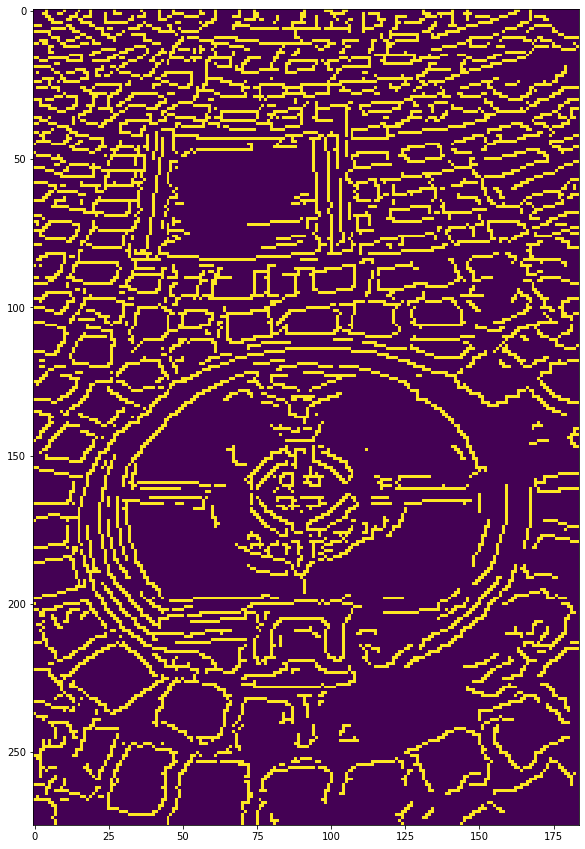

In [1254]:
t = 13
edge = EDGE[t]
fig = plt.figure(figsize=(15,15))
plt.imshow(edge)

In [1255]:
LS = lineExtraction(edge)
# len(LS[0])+len(LS[1])+len(LS[2])+len(LS[3])

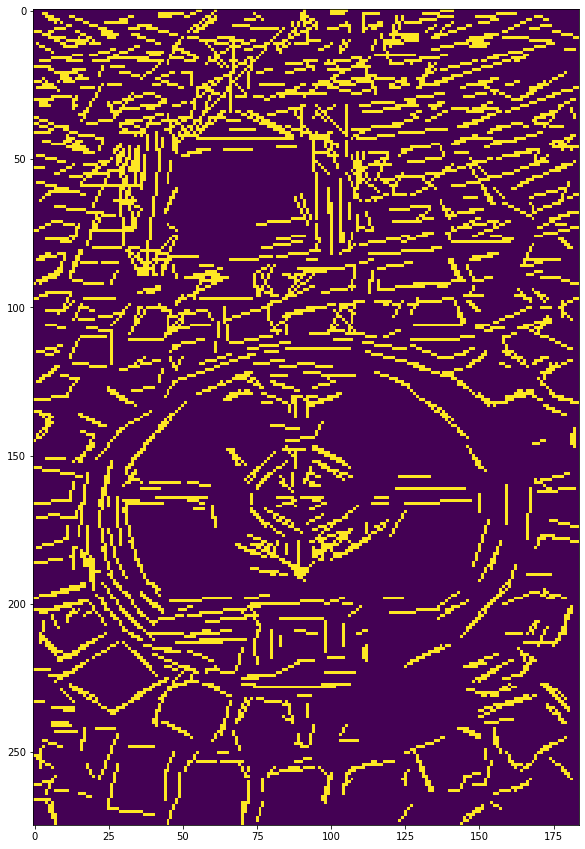

In [1256]:
lineImg = np.zeros(edge.shape)
for grp in range(len(LS)):
    test = LS[grp]
    for testLine in test:
        (x1, y1) = testLine[0]
        (x2, y2) = testLine[1]
        cv2.line(lineImg, (x1, y1), (x2, y2), (255,255,255), 1)
fig = plt.figure(figsize=(15,15))
plt.imshow(lineImg)

In [1257]:
AS = arcExtraction(LS)

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(15,15))
arcImg = np.zeros(edge.shape)
for g in range(len(AS)):
    ASg = AS[g]
    for i in range(len(ASg)):
        lines = ASg[i]
        for j in range(len(lines)):
            line = lines[j]
            cv2.line(arcImg, LS[g][line][0], LS[g][line][1], (255,255,255), 1)
plt.imshow(arcImg)

In [1229]:
AS

[[[18, 16],
  [67, 60],
  [68, 56],
  [132, 150],
  [136, 135],
  [145, 143],
  [148, 135],
  [133, 141, 137, 140]],
 [[111, 108], [118, 107], [120, 112, 115], [114, 117, 106, 110, 109]],
 [[11, 13],
  [12, 13],
  [33, 34],
  [59, 61],
  [83, 100],
  [96, 97],
  [115, 109],
  [153, 145],
  [148, 147, 149],
  [151, 160, 146, 161]],
 [[29, 35], [96, 95, 85], [87, 92, 97, 89, 88, 90]]]

In [1249]:
num = -1

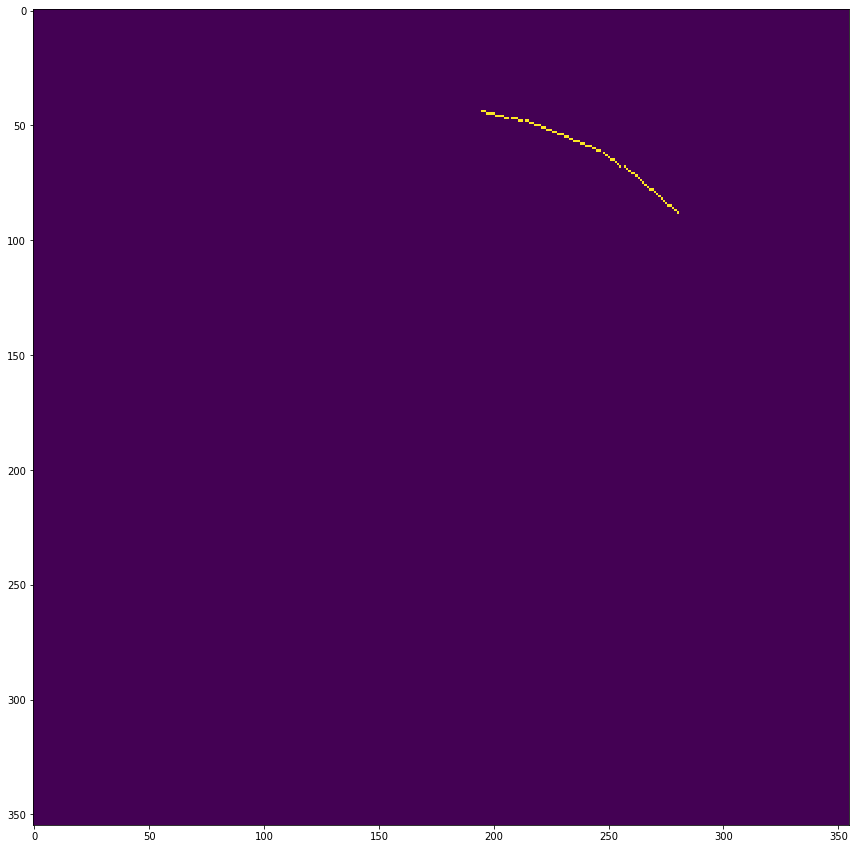

In [1253]:
fig = plt.figure(figsize=(15,15))
arcImg = np.zeros(edge.shape)

grp = 1
ASg = AS[grp]

num = num + 1
arc = ASg[num]

for i in range(len(arc)):
    lineNum = arc[i]
    cv2.line(arcImg, LS[grp][lineNum][0], LS[grp][lineNum][1], (255,255,255), 1)
plt.imshow(arcImg)

# Try to detect basing on ARC

In [157]:
def IOU(img1, img2):
    
    I = int(np.sum(img1 & img2))
    U = int(np.sum(img1 | img2))
    out = round((I / U), 4)
    
    return out

In [167]:
def arcSplice(img, P, times):
    
    N = list()
    V = list()
    F = list()
    E = list()
    O = list()
    
    for i in range(len(P)):
        print('\nGroup', i)
        (num, voters, function) = bestEllipse(P[i], P, times)
        (ellipse, focuses) = ellipseParemeters(function)
        N.append(num)
        V.append(voters)
        F.append(function)
        E.append(ellipse)
        O.append(focuses)
        
    # to detect if the ellipses are actually the same one
    
    # calculate the IoU of every two eclipses
    pics = list()
    delete = list()
    img = np.zeros((img.shape[0], img.shape[1]), img.dtype)
    
    print('There are', len(P), 'ellipses detected.')
    
#     for i in range (len(P)):
#         if (np.isnan(E[i][0][0] * E[i][0][1] * E[i][1][0] * E[i][1][1] * E[i][2])):
#             E[i] = ((0,0),(0,0),0)
#         cv2.ellipse(img, E[i], (1, 0, 0), -1)
#         pics.append(img)
#     for i in range(len(pics)-1):
#         for j in range(i+1, len(pics)):
#             iou = IOU(pics[0], pics[1])
#             if iou > 0.95:
#                 if i not in delete:
#                     if j not in delete:
#                         delete.append(i)
#                         delete.append(j) 
                
#                         N.append(N[i] + N[j])
#                         V.append(V[i] + V[j])
#                         func = ((N[i]*F[i].T + N[j]*F[j].T)/(N[i]+N[j])).T
#                         F.append(func)
#                         (elli, focu) = ellipseParemeters(func)
#                         E.append(elli)
#                         O.append(focu)
#     print(F)
#     print(delete)
#     for i in range(len(delete)):
#         N.pop(i)
#         V.pop(i)
#         F.pop(i)
#         E.pop(i)
#         O.pop(i)
                
    return (N, V, F, E, O)

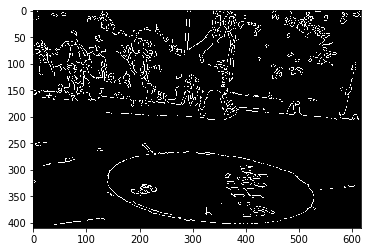

In [159]:
img = EDGE[4]
plt.imshow(img, 'gray')

In [160]:
cnt = findCNT(killLines(img))
grp = cnt
for i in range(len(cnt)):
    grp[i] = cnt[i].reshape(cnt[i].shape[0], 2)

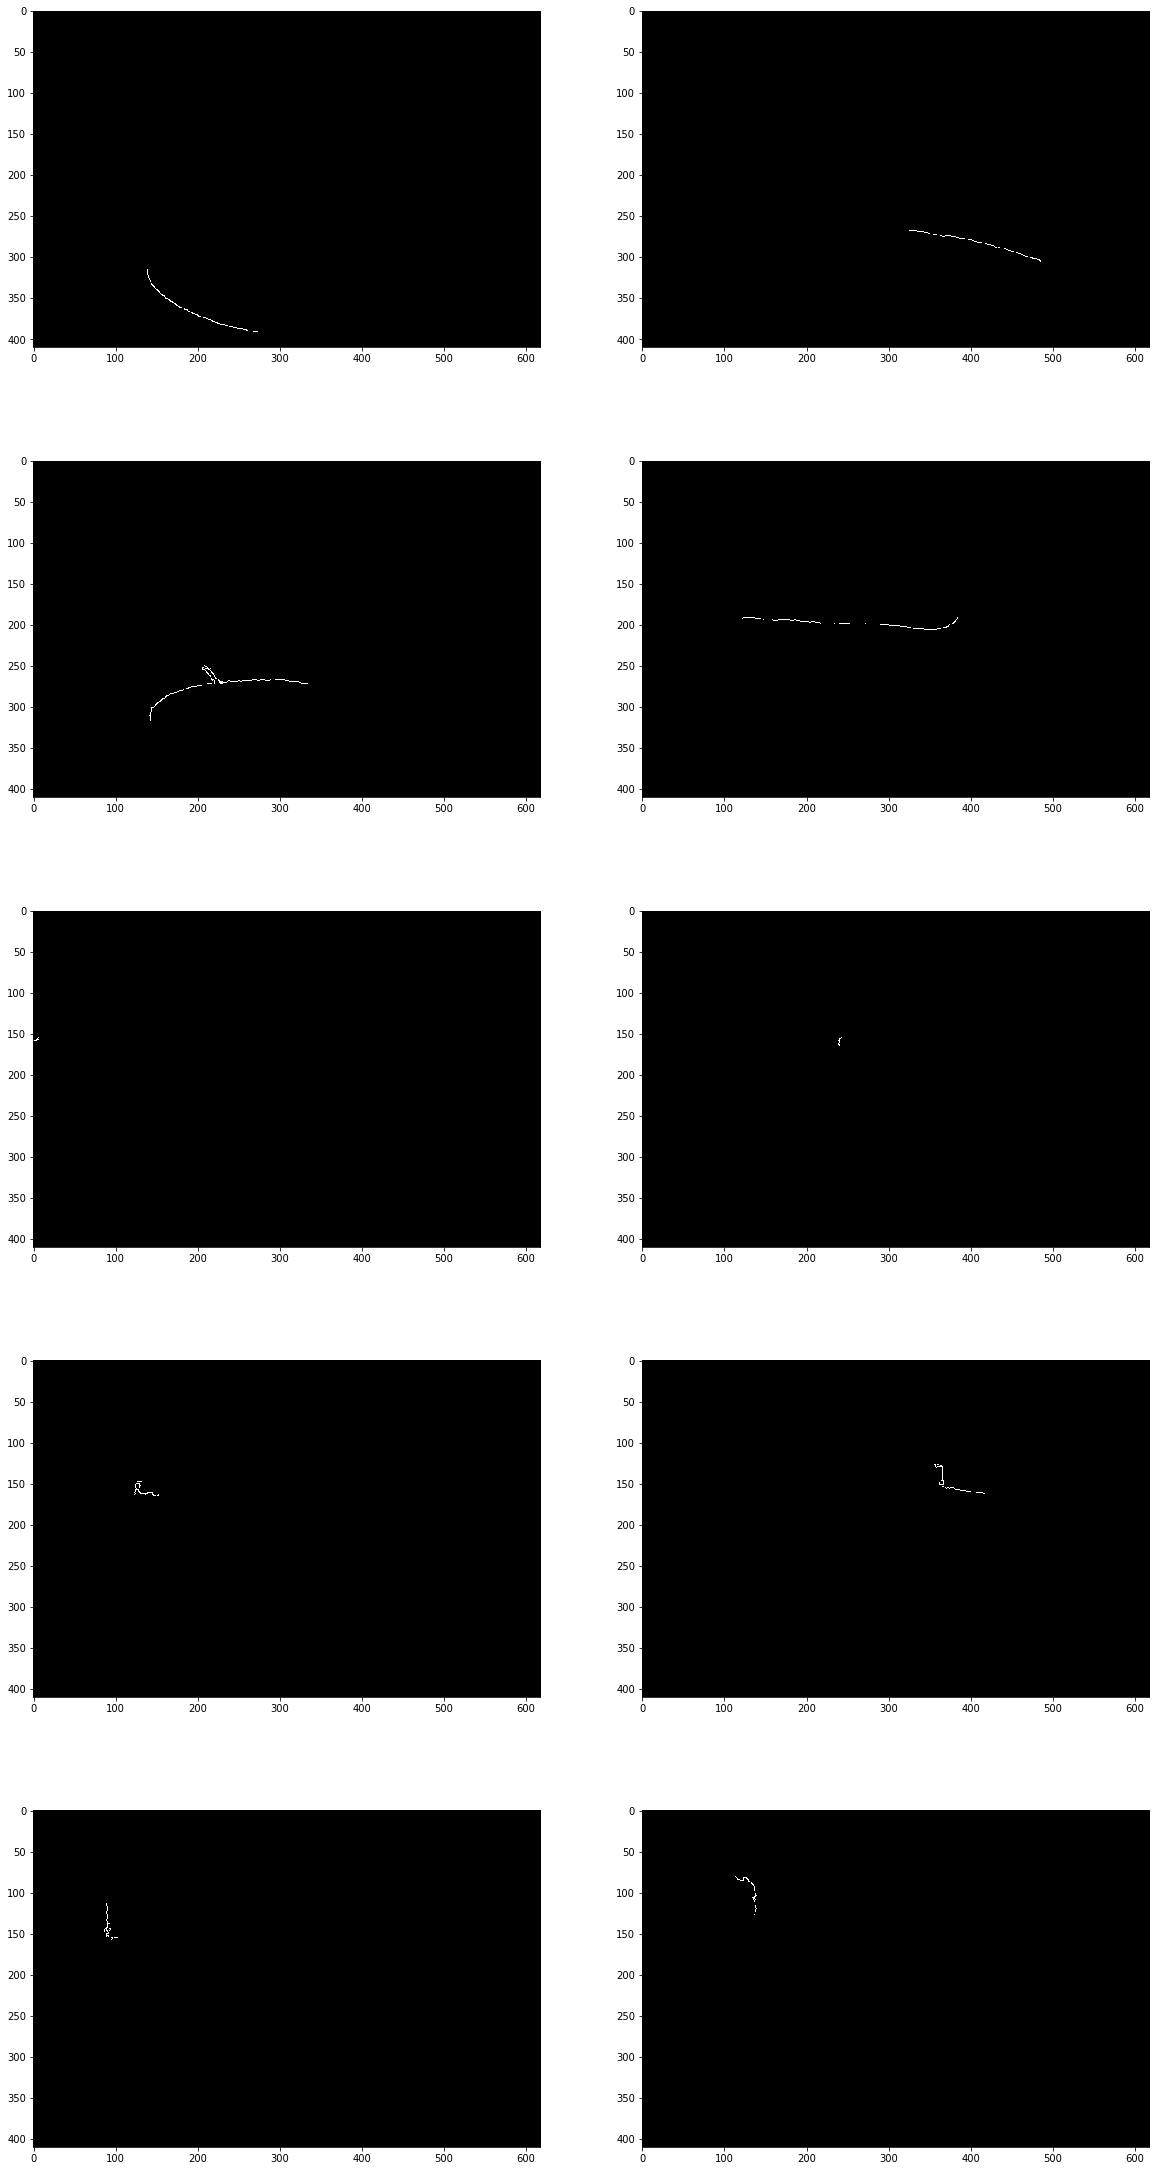

In [161]:
fig = plt.figure(figsize = (20,40))
for i in range(len(cnt)):
    img_full = np.zeros(img.shape, img.dtype)
    cv2.drawContours(img_full, [cnt[i]], 0, (255, 255, 0), -1)
    plt.subplot((int(len(cnt)+1)/2), 2, i+1)
    plt.imshow(img_full, 'gray')

In [168]:
(N, V, F, E, O) = arcSplice(img, grp, 50)


Group 0

Group 1

Group 2

Group 3

Group 4

Group 5

Group 6

Group 7

Group 8

Group 9
There are 10 ellipses detected.


/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


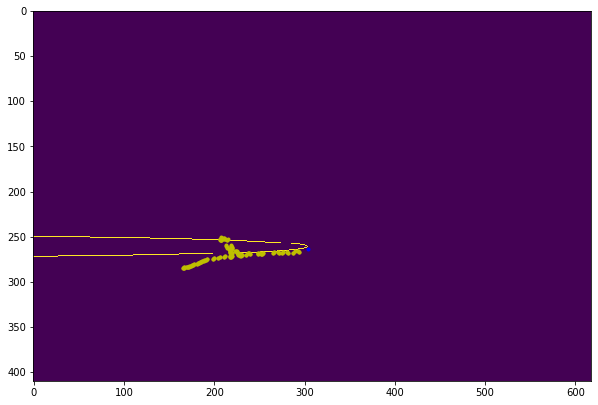

In [181]:
fig = plt.figure(figsize = (10,10))
temp = np.zeros(img.shape, img.dtype)
cv2.ellipse(temp, E[0], (255, 0, 0), 1)
plt.plot(O[0][:, 0], O[0][:, 1], 'b.', label = "Focuses")
plt.plot(np.array(V[0])[:, 0], np.array(V[0])[:, 1], 'y.', label = "Voters")
plt.imshow(temp)

In [ ]:
a = np.array([[1,2,3],
             [4,5,6]])